Problem Statement

Click prediction : to predict how often a hotel will be clicked based on its characteristics.

Data 

Target Variable: 
    n clicks: the number of clicks the hotel has received.

Feature Variable:
    1. hotel id: a number uniquely identifying each hotel.
    2. city id: describes the city the hotel is located in.
    3. content score: describes the quality of the content that is provided for the hotel on a scale from 0 (worst) to 100 (best).
    4. n images: number of images that are available for the given hotel.
    5. distance to center: distance (in meters) of the hotel to the nearest city center.
    6. avg rating: average rating of the hotel on a scale from 0 (worst) to 100 (best).
    7. n reviews: number of reviews that are available for that hotel.
    8. avg rank: average position the hotel had in the list.
    9. avg price: average price in Euro of the hotel.
    10.avg saving percent: average saving users achieve on this hotel by using trivago.


Given training set has 396487 observations and 132162 observations for test set.

Final model, a mix of both classification and regression technique, is built to predict n_clicks. 

I have followed standard data munging pipeline, namely (1) data cleaning, (2) feature engineering (3) exploratory data analysis and (4) model building. 




In [1]:
#Starting with loading required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from scipy import interp
import scipy.stats as st
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

I have downloaded and saved the data in a local folder.
Let's load the train and test file seperately and merge it to a single dataframe(df) and work on this to avoid repetition of any modifications done before building the model.

In [2]:
train=pd.read_csv("C:/Users/Toshiba/Downloads/Submissions/Trivago/train_set.csv")
test_m=pd.read_csv("C:/Users/Toshiba/Downloads/Submissions/Trivago/test_set.csv")
train['Type']='Train' #Create a flag for Train and Test Data set
test_m['Type']='Test'
df = pd.concat([train,test_m],axis=0) #Combined both Train and Test Data set
df.shape,train.shape,test_m.shape

((528649, 13), (396487, 13), (132162, 12))

In [3]:
#df.info() # checking if the datatype is correct or not
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528649 entries, 0 to 132161
Data columns (total 13 columns):
Type                  528649 non-null object
avg_price             528421 non-null float64
avg_rank              528649 non-null float64
avg_rating            381621 non-null float64
avg_saving_percent    528421 non-null float64
city_id               527986 non-null float64
content_score         527986 non-null float64
distance_to_center    527957 non-null float64
hotel_id              528649 non-null float64
n_clicks              396487 non-null float64
n_images              527984 non-null float64
n_reviews             527957 non-null float64
stars                 527912 non-null float64
dtypes: float64(12), object(1)
memory usage: 56.5+ MB


This dataset seeems to have highly skewed continous features. Let's explore more by visually examining its distribution

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_price,528421.00,109.18,147.38,4.00,51.00,77.60,120.95,8000.00
avg_rank,528649.00,14.70,5.62,1.00,11.08,15.00,18.39,100.00
avg_rating,381621.00,81.62,6.02,34.00,79.00,83.00,86.00,98.00
avg_saving_percent,528421.00,7.16,13.06,0.00,0.00,0.00,10.00,100.00
city_id,527986.00,149207.27,219290.12,2.00,32010.00,55122.00,137456.00,878736.00
content_score,527986.00,50.98,11.57,7.00,45.00,53.00,59.00,81.00
distance_to_center,527957.00,16139.15,269024.54,0.00,544.00,1515.00,4162.00,18341550.00
hotel_id,528649.00,132668050617.89,103420473052.88,155796153.00,40701082970.00,108602473300.00,228375353198.00,323711383754.00
n_clicks,396487.00,13.78,123.57,0.00,0.00,0.00,2.00,13742.00
n_images,527984.00,283.76,18293.67,-1.00,0.00,1.00,2.00,2628317.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002790CD5B588>,
      dtype=object)

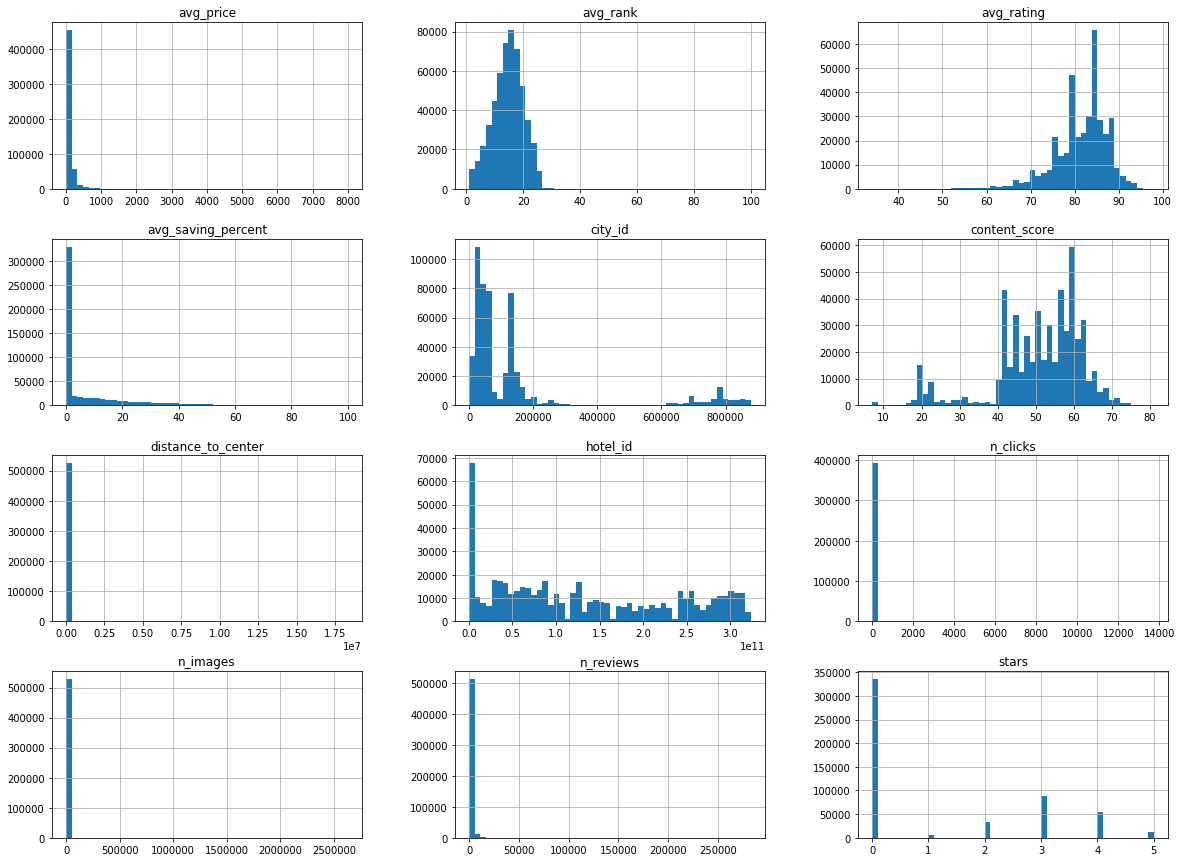

In [5]:
df.hist(bins=50,figsize=(20,15))

Keeping this skewness trend and occurence of 0 as most frequent observation in number of clicks variable, let's 
continue with the data cleaning part especially removal of missing values and outliers.

In [6]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

To Drop or Not to Drop

It should be noted that our test data don't have n_clicks(target) and hence missing value for the variable showing higher numbers.

One column avg rating has high missing value share in its column which is eliminated from further analysis as imputing na s with mean/median will be a pure guessing and can make biases on the final target variable since this data already has many columns with high variances. 

I believe dropping data is always a harsh step and should be taken only in extreme conditions.But in this case, we have too many observations and missing values are few, then we can think of dropping these observations(entire row) with missing value; thus,removed entire NA's 

Although the problem is predicting a numerical value(number of clicks) , n_clicks=0 is the most often occuring case and if we build a regression model with features that have very high variances, the resultant prediction might not capture the same pattern of high occurance of n_clicks=0. Keeping in mind this problem, my attempt to solve this regression problem is by first predicting whether there is high chance of target(n_clicks) is zero or not; A binary classification problem, and if the target is greater than 0, then predict the number of clicks(n_clicks); A regression model

Include logarithmic values of those numerical features which are highly skewed with high value outliers. To avoid correlation between features, I am dropping those original features whose logarithmic values are created.

In [7]:
def engineer_features(adata):
    # make copy of the original dataset
    data = adata.copy()
    data=data.drop(['avg_rating'],axis=1)
    data['city_id']=data['city_id'].astype('category')
    data['stars']=data['stars'].astype('category')
    data['dist_to_center_km']=data['distance_to_center']/1000
    data['n_images']=data['n_images'].abs()
    data['image']=data['n_images'].apply(lambda x: '0' if x < 1 else '1')
    data['review']=data['n_reviews'].apply(lambda x: '0' if x < 1 else '1')
    data['log_distance'] = data['dist_to_center_km'].apply(lambda x: np.log(x+1))
    data['log_image'] = data['n_images'].apply(lambda x: np.log(x+1))
    data['log_review'] = data['n_reviews'].apply(lambda x: np.log(x+1))

    return data
   

          
                 
                 

In [8]:
df=engineer_features(df)

In [9]:
# Seperating train and test set from data
train_m=df[df['Type']=='Train']
test_m=df[df['Type']=='Test']
# Dropping training set observations with NA s as occurence of NA s are miniscule comapred to our overall train size
train=train_m.dropna()
test_m=test_m.drop(['n_clicks'],axis=1)
# Keeping the test set as such and assign test set with no NA s to new dataframe (test)
test=test_m.dropna()
#Creating our new target variable 'click'
train['click']=train['n_clicks'].apply(lambda x: '0' if x < 1 else '1') 


In [10]:
corr_matrix = train.corr()
corr_matrix["n_clicks"].sort_values(ascending=False)

n_clicks              1.00
n_reviews             0.22
log_image             0.13
avg_saving_percent    0.13
log_review            0.12
content_score         0.10
avg_price             0.02
n_images              0.00
dist_to_center_km    -0.00
distance_to_center   -0.00
log_distance         -0.01
avg_rank             -0.08
hotel_id             -0.10
Name: n_clicks, dtype: float64

Checking missing values...

In [11]:
missing_values_table(test)

Your selected dataframe has 17 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [12]:
train_m.shape,train.shape,test_m.shape,test.shape

((396487, 18), (395760, 19), (132162, 17), (131929, 17))

In [13]:
features_todrop_train=['Type','distance_to_center','n_images', 'n_reviews','dist_to_center_km', 'image','review','n_clicks']
features_todrop_test=['Type','distance_to_center','n_images', 'n_reviews','dist_to_center_km', 'image','review']

train=train.drop(features_todrop_train,axis=1)
test=test.drop(features_todrop_test,axis=1)

y = train.pop('click')
encoded_column_vector = label_binarize(y, classes=['0','1']) 
y = np.ravel(encoded_column_vector) # Reshape array
X = train

In [14]:
train.columns,y.shape

(Index(['avg_price', 'avg_rank', 'avg_saving_percent', 'city_id',
        'content_score', 'hotel_id', 'stars', 'log_distance', 'log_image',
        'log_review'],
       dtype='object'), (395760,))

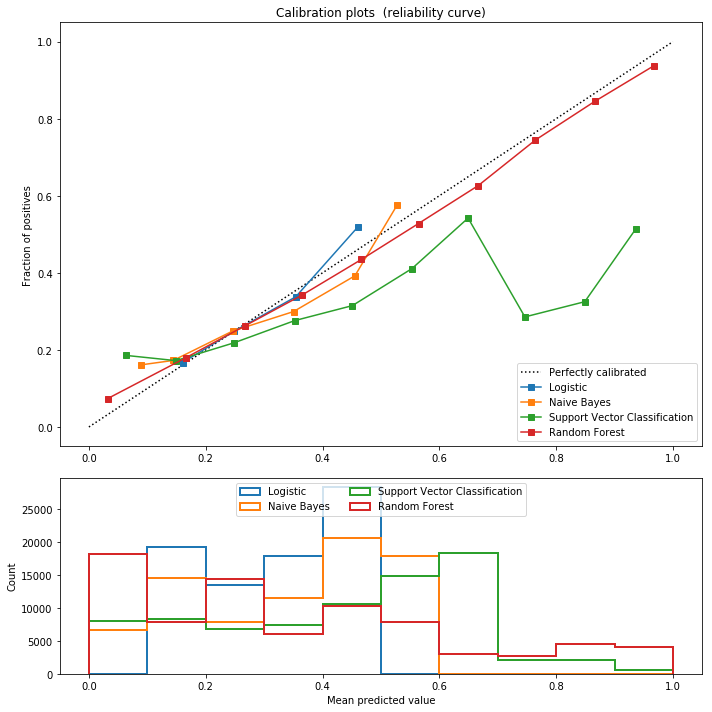

In [15]:
# Selecting the best classification model from a list of classifiers

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=15)

# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Perfectly calibarated model is RandomForest Classifier, which is selected to build final model; it's ROC analysis is also done to understand the best threshold value. StratifiedKFold cross validation method is used that helps to build a more generalized model with less overfitting.

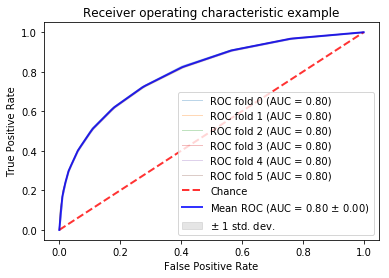

In [16]:
# Random Forest Classification and ROC analysis
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = RandomForestClassifier()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for trn, tst in cv.split(X, y):
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [17]:
y_pred=classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)


array([[46248,  5539],
       [13440, 13925]], dtype=int64)

[]

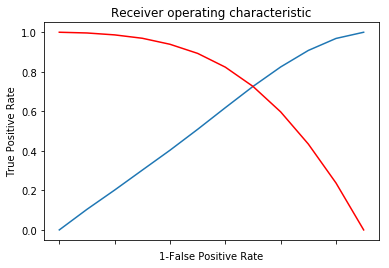

In [18]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])
#ax.set_yticklabels([])

In [19]:
train.shape,test.shape,test_m.shape

((395760, 10), (131929, 10), (132162, 17))

In [20]:
# Find prediction to the dataframe applying threshold=0.3 as deducted from the plot above
test['y_prob_rf'] = classifier.predict_proba(test)[:, 1]
test['y_rf'] = test['y_prob_rf'].map(lambda x: 1 if x > 0.3 else 0)


Merge the predicted class with the main test set which has all observations including NA s

In [21]:
test_m = pd.merge(test_m,test[['hotel_id','y_prob_rf', 'y_rf']], left_on='hotel_id', right_on='hotel_id',
                   how='left')

predicted value y_pred is assigned value 1 for all observations i.e including NA s except for y_pred equals 0

In [22]:
test_m['y_pred']=test_m['y_rf'].apply(lambda x: '0' if x == 0 else '1')

to_drop_col=['Type','dist_to_center_km','distance_to_center','image', 'review','n_images',
       'n_reviews','y_prob_rf', 'y_rf']
test_m.drop(to_drop_col,axis=1,inplace=True)

To include all observations in the test set to predict the number of clicks(n_clicks) i.e including test set observations with NA s in its features, median imputation i.e fill NA s with respective columns median value and if it's categorical type, impute most frequent observation of those respective column, so that we can elimiante all NA s in the test set for modelling purpose. 

In [23]:
def median_impute(adata):
    
    data = adata.copy()    
    data['log_distance'] = data['log_distance'].fillna((data['log_distance'].median()))
    data['log_review'] = data['log_review'].fillna((data['log_review'].median()))
    data['log_image'] = data['log_image'].fillna((data['log_image'].median()))
    data['content_score'] = data['content_score'].fillna((data['content_score'].median()))
    data['avg_price'] = data['avg_price'].fillna((data['avg_price'].median()))
    data['avg_saving_percent'] = data['avg_saving_percent'].fillna((data['avg_saving_percent'].median()))
    return data


In [24]:
test_m=median_impute(test_m)
test_m = test_m.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [25]:
##Test set has same number of observations as given 
test_m.shape


(132162, 11)

Now, divide test set to two dataframe, one with predicted number of clicks equals 0 and other whose predicted number of clicks
equal to 1. As said before, our aim is to modify the number of clicks for the test set with predicted value equals 1 and keep
the dataframe with n_clicks=0 as such.


In [26]:
test_m_val0=test_m[test_m['y_pred']=='0']
test_m_val1=test_m[test_m['y_pred']=='1']

In [27]:
train_m=train_m.dropna()
features_todrop_train_m=['Type','distance_to_center','n_images','n_reviews','dist_to_center_km','image','review']
df_train=train_m.drop(features_todrop_train_m,axis=1)

In [28]:
df_train.columns,df_train.shape

(Index(['avg_price', 'avg_rank', 'avg_saving_percent', 'city_id',
        'content_score', 'hotel_id', 'n_clicks', 'stars', 'log_distance',
        'log_image', 'log_review'],
       dtype='object'), (395760, 11))

Understanding the outliers is a bit tricky here; for sure, the effect of outliers in the regression model is going to
worsen the model's predictive capability.

Since we have the luxury of many number of train set observations, we can easily discard outlier values that look
very unrealistic and huge. For this purpose, I am creating upper threshold at 0.99 percentile and discarding 0.01 precentile
observation from the training set.

In [29]:
df_train['log_distance'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,0.98,0.99,0.999, 1])

0.00   0.00
0.10   0.16
0.20   0.35
0.30   0.52
0.40   0.71
0.50   0.92
0.60   1.17
0.70   1.47
0.80   1.83
0.90   2.38
0.98   3.84
0.99   4.81
1.00   7.94
1.00   9.82
Name: log_distance, dtype: float64

In [30]:
upper_images=np.percentile(df_train['log_image'],99.9)
upper_reviews=np.percentile(df_train['log_review'],99.9)
upper_clicks=np.percentile(df_train['n_clicks'],99.9)
upper_distance=np.percentile(df_train['log_distance'],99.9)

df_train=df_train[(df_train["n_clicks"]<upper_clicks)]
print(df_train.shape)
df_train=df_train[(df_train["log_image"]<upper_images)]
print(df_train.shape)
df_train=df_train[(df_train["log_review"]<upper_reviews)]
print(df_train.shape)
df_train=df_train[(df_train["log_distance"]<upper_distance)]
print(df_train.shape)


(395364, 11)
(394964, 11)
(394590, 11)
(394194, 11)


In [31]:
#Defining weighted mean squared error which is the evaluation metric used for checking model accuracy
def weighted_mse(y_test,y_pred):
    w_i = np.log(y_test + 1) + 1
    w = np.sum(w_i)
    mse = np.sum(np.multiply(w_i, np.square(y_pred - y_test)))
    final = mse / w * len(y_test)
    return final

In [32]:

y = df_train.pop('n_clicks')
X = df_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=324)

##########BASE MODEL######
from sklearn.linear_model import LinearRegression
regressor_lr = LinearRegression()
regressor_lr.fit(X_train, y_train)
y_pred_lr = regressor_lr.predict(X_test)
print("weighted mse of Base model is: ",weighted_mse(y_test,y_pred_lr))
######### RANDOM FOREST REGRESSOR #####
from sklearn.ensemble import RandomForestRegressor
regr_rf = RandomForestRegressor(random_state=0,n_estimators=100)
regr_rf.fit(X_train, y_train)
RandomForestRegressor(bootstrap=True, criterion='mse',
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
#print(regr_rf.feature_importances_)
y_pred=regr_rf.predict(X_test)
print("weighted mse of RF model is: ",weighted_mse(y_test,y_pred))


weighted mse of Base model is:  1138170431.8757913
weighted mse of RF model is:  637962677.9261893


In [33]:
test_m_val1.head()

,avg_price,avg_rank,avg_saving_percent,city_id,content_score,hotel_id,stars,log_distance,log_image,log_review,y_pred
0,90.19,13.50,32.00,122750.00,58.00,14942256073.00,0.00,2.53,1.10,5.13,1
1,98.27,13.67,19.00,28134.00,68.00,16036037903.00,5.00,0.66,1.61,6.60,1
3,72.32,15.00,0.00,54398.00,47.00,129041645070.00,0.00,0.99,0.00,4.25,1
6,141.94,15.45,4.00,137162.00,57.00,68479216174.00,1.00,0.14,0.69,6.60,1
7,42.87,17.48,43.00,247132.00,59.00,80414273157.00,0.00,1.00,0.69,6.13,1


In [34]:
list(zip(X_train, regr_rf.feature_importances_))

[('avg_price', 0.08801292235420548),
 ('avg_rank', 0.14134488385301455),
 ('avg_saving_percent', 0.10032231208567433),
 ('city_id', 0.23099206751462906),
 ('content_score', 0.04209367119445367),
 ('hotel_id', 0.11794682807961943),
 ('stars', 0.029918153358612996),
 ('log_distance', 0.06104673312822602),
 ('log_image', 0.04130864391676314),
 ('log_review', 0.14701378451480143)]

In [35]:
test_m_val1.drop('y_pred',axis=1,inplace=True)
test_m_val1['y_pred'] =np.round(regr_rf.predict(test_m_val1))
test_m_final=test_m_val0.append(test_m_val1)



In [36]:
submission=['hotel_id','y_pred']
df_submission=test_m_final[submission]

In [39]:
df_submission.to_csv('submission.csv')